# Exploración con k-nearest neighbors


In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pandas.plotting import parallel_coordinates

# Modelos y validación
from sklearn.model_selection import (
    train_test_split,   
    StratifiedKFold,    
    GridSearchCV     
)

# KNN
from sklearn.neighbors import KNeighborsClassifier     

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    balanced_accuracy_score
)

# Configuramos las opciones de pandas y seaborn para mejorar la visualización de datos
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

df = pd.read_csv('../data/processed/diabetes_sample.csv')
df.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0
1,0.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,30.0,0.0,0.0,0.0,7.0,5.0,8.0
2,0.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,6.0,8.0
3,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
4,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,8.0


In [2]:
target_col =  'Diabetes_012'
X = df.drop(columns=[target_col])
y = df[target_col]


print("Variables separadas:")
print(f"   X: {X.shape} → {X.shape[1]} features")
print(f"   y: {y.shape} → {y.nunique()} clases")
print(f"Features:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

Variables separadas:
   X: (38052, 21) → 21 features
   y: (38052,) → 3 clases
Features:
    1. HighBP
    2. HighChol
    3. CholCheck
    4. BMI
    5. Smoker
    6. Stroke
    7. HeartDiseaseorAttack
    8. PhysActivity
    9. Fruits
   10. Veggies
   11. HvyAlcoholConsump
   12. AnyHealthcare
   13. NoDocbcCost
   14. GenHlth
   15. MentHlth
   16. PhysHlth
   17. DiffWalk
   18. Sex
   19. Age
   20. Education
   21. Income


In [ ]:
Y = df['Diabetes_012']
X = df.drop(columns=["Diabetes_012"])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, 
    random_state=2, 
    stratify=Y
)

print("Datos divididos en entrenamiento y prueba:")
print(f"   X_train: {X_train.shape[0]} samples")   
print(f"   X_test : {X_test.shape[0]} samples")
print(f"   y_train: {y_train.shape[0]} samples")
print(f"   y_test : {y_test.shape[0]} samples")



Datos divididos en entrenamiento y prueba:
   X_train: 30441 samples
   X_test : 7611 samples
   y_train: 30441 samples
   y_test : 7611 samples


In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos escalados con StandardScaler.")

Datos escalados con StandardScaler.


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model_knn = KNeighborsClassifier()

params_knn = model_knn.get_params()
print("\nParámetros del modelo KNN:")
for param, valor in sorted(params_knn.items()):
    print(f"{param:25s} = {valor}")


Parámetros del modelo KNN:
algorithm                 = auto
leaf_size                 = 30
metric                    = minkowski
metric_params             = None
n_jobs                    = None
n_neighbors               = 5
p                         = 2
weights                   = uniform


In [15]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31],   
    'weights': ['uniform', 'distance'],            
    'p': [1, 2]                                    #(1=Manhattan, 2=Euclídea)
}

# GridSearchCV para KNN
grid_search_knn = GridSearchCV(
    estimator=model_knn,
    param_grid=param_grid_knn,
    scoring='balanced_accuracy',       
    cv=cv,
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

start_time = time.time()
grid_search_knn.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Tiempo de ejecución del Grid Search: {end_time - start_time:.2f} segundos")

results_knn = pd.DataFrame(grid_search_knn.cv_results_)
mejor_modelo_knn = grid_search_knn.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Tiempo de ejecución del Grid Search: 286.58 segundos


In [16]:
best_index = grid_search_knn.best_index_
best_row = results_knn.loc[best_index]

mean_cv_score = best_row['mean_test_score']
mean_train_score = best_row['mean_train_score']

print("Mejor Modelo (Resultados de CV)")
print(f"Mejor Parámetros: {grid_search_knn.best_params_}")
print(f"Balanced Accuracy (CV Mean): {mean_cv_score:.4f}")
print(f"Balanced Accuracy (Train Mean): {mean_train_score:.4f}")

Mejor Modelo (Resultados de CV)
Mejor Parámetros: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Balanced Accuracy (CV Mean): 0.3952
Balanced Accuracy (Train Mean): 0.9916


In [17]:
columns_target = [
    'param_n_neighbors',
    'param_weights',
    'param_p',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

# Subset ordenado por el ranking del score
results_subset_knn = results_knn[columns_target].copy()
results_subset_knn = results_subset_knn.sort_values(by='rank_test_score')

print("\nResultados resumidos de la búsqueda ordenados por score:")
print(results_subset_knn.to_string(index=False))


Resultados resumidos de la búsqueda ordenados por score:
 param_n_neighbors param_weights  param_p  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score
                 3      distance        1          0.991595         0.001440         0.395228        0.005201                1
                 3       uniform        1          0.503893         0.003490         0.391722        0.003807                2
                 3      distance        2          0.991889         0.001561         0.391516        0.002221                3
                 3       uniform        2          0.502636         0.005862         0.388213        0.001602                4
                 5      distance        2          0.991693         0.001456         0.386896        0.003902                5
                 5      distance        1          0.991595         0.001440         0.386869        0.004089                6
                 7      distance        1          0.

In [20]:
overfitting_gap = mean_train_score - mean_cv_score

print(f"Gap (Train - CV): {overfitting_gap:.4f}")

if overfitting_gap > 0.05: # Umbral de ejemplo, a ajustar por el analista
    print("Posible Overfitting: El modelo funciona mucho mejor en entrenamiento que en validación.")
elif overfitting_gap < 0.01:
    print("Generalización Sólida: El rendimiento de entrenamiento y validación es muy similar.")
else:
    print("Generalización Aceptable: Existe una pequeña diferencia, típica en el modelado.")

Gap (Train - CV): 0.5964
Posible Overfitting: El modelo funciona mucho mejor en entrenamiento que en validación.


In [ ]:

y_pred_test = mejor_modelo_knn.predict(X_test_scaled) 

print("\nMÉTRICAS DE CLASIFICACIÓN EN TEST")

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_test))

print("F1-score (macro):", f1_score(y_test, y_pred_test, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_test, average='macro'))

print("\nREPORTE DETALLADO")
# El Classification Report es el más valioso, pues muestra el rendimiento por cada clase
target_names = ['No Diabetes', 'Pre-diabetes', 'Diabetes'] # Ajustar si tienes otras clases
print(classification_report(y_test, y_pred_test, target_names=target_names, digits=4))




MÉTRICAS DE CLASIFICACIÓN EN TEST
Balanced Accuracy: 0.39479500240248483
F1-score (macro): 0.40127097138128015
Recall (macro): 0.39479500240248483

REPORTE DETALLADO
              precision    recall  f1-score   support

 No Diabetes     0.8700    0.9244    0.8963      6412
Pre-diabetes     0.0185    0.0072    0.0104       139
    Diabetes     0.3602    0.2528    0.2971      1060

    accuracy                         0.8141      7611
   macro avg     0.4162    0.3948    0.4013      7611
weighted avg     0.7834    0.8141    0.7967      7611



In [26]:
cv_ba = grid_search_knn.best_score_

y_pred_train = mejor_modelo_knn.predict(X_train_scaled)
ba_train = balanced_accuracy_score(y_train, y_pred_train)

y_pred_test = mejor_modelo_knn.predict(X_test_scaled)
ba_test = balanced_accuracy_score(y_test, y_pred_test)

print("\n--- Balanced Accuracy (BA) Comparativa Final ---")
print(f"Train:           BA = {ba_train:.4f}")
print(f"Validation (CV): BA = {cv_ba:.4f}")
print(f"Test:            BA = {ba_test:.4f}")


--- Balanced Accuracy (BA) Comparativa Final ---
Train:           BA = 0.9901
Validation (CV): BA = 0.3952
Test:            BA = 0.3948


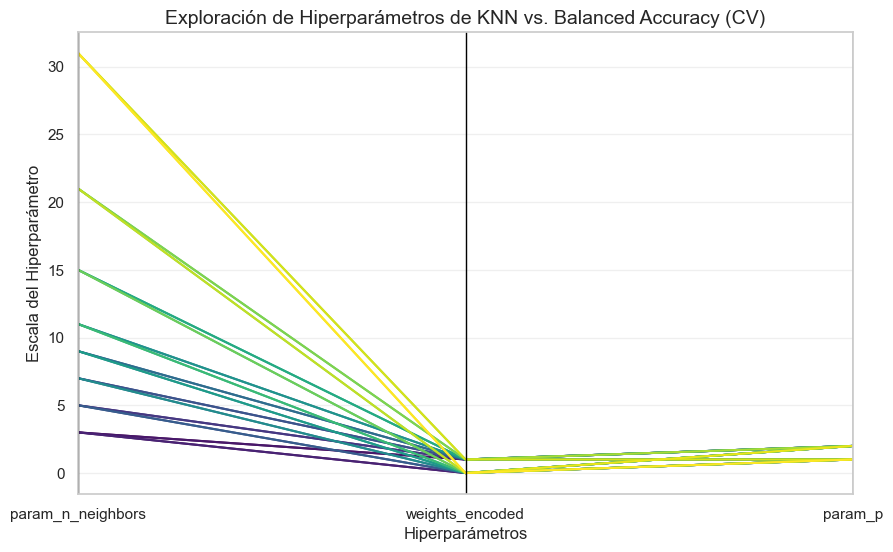

In [29]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
results_knn = results_knn.rename(columns={'mean_test_score': 'Balanced_Accuracy_CV'})

data_for_plot = results_knn[[
    'param_n_neighbors', 
    'param_weights', 
    'param_p', 
    'Balanced_Accuracy_CV'
]].copy()

weight_mapping = {'uniform': 0, 'distance': 1}
data_for_plot['weights_encoded'] = data_for_plot['param_weights'].map(weight_mapping)

data_for_plot = data_for_plot.sort_values(by='Balanced_Accuracy_CV', ascending=False)

plt.figure(figsize=(10, 6))

# Usar el score como el color
parallel_coordinates(
    data_for_plot, 
    class_column='Balanced_Accuracy_CV', 
    cols=['param_n_neighbors', 'weights_encoded', 'param_p'],
    colormap='viridis' # Un mapa de colores que muestra la intensidad del score
)

plt.title('Exploración de Hiperparámetros de KNN vs. Balanced Accuracy (CV)', fontsize=14)
plt.xlabel('Hiperparámetros')
plt.ylabel('Escala del Hiperparámetro')
plt.grid(True, alpha=0.3)
plt.legend([],[], frameon=False) # Eliminar leyenda automática y usar la barra de color
plt.show()


In [32]:
print("EJEMPLO DE PREDICCIÓN CON PACIENTES REALES (Modelo KNN)")

n_ejemplos = 5
# 1. Seleccionar los índices aleatorios del conjunto de prueba
indices_aleatorios = np.random.choice(len(X_test), size=n_ejemplos, replace=False)

# 2. Preparar los datos
# Obtenemos las características ORIGINALES para la visualización
pacientes_ejemplo_original = X_test.iloc[indices_aleatorios]
# Obtenemos las características ESCALADAS para la predicción del modelo KNN
pacientes_ejemplo_scaled = X_test_scaled[indices_aleatorios] # X_test_scaled es un array de NumPy
realidad = y_test.iloc[indices_aleatorios]

print(f"\nAnalizando {n_ejemplos} pacientes del test set...\n")

# 3. Hacer predicciones
predicciones = mejor_modelo_knn.predict(pacientes_ejemplo_scaled)
# NOTA: KNN no devuelve probabilidades, devuelve la proporción de votos (probas).
probabilidades = mejor_modelo_knn.predict_proba(pacientes_ejemplo_scaled)

# 4. Mapeo de clases (Asumiendo que las clases son 0, 1, 2)
clase_nombres = {0: 'No Diabetes', 1: 'Pre-diabetes', 2: 'Diabetes'}

# 5. Mostrar resultados paciente por paciente
for i, idx in enumerate(indices_aleatorios):
    print("="*70)
    print(f"PACIENTE #{idx}")
    print("="*70)
    
    # Características del paciente (Usamos el set NO escalado para que sea legible)
    print("\nCaracterísticas del paciente:")
    print("-"*70)
    # Seleccionamos las primeras 10 columnas para no saturar la salida
    for col_name in X_test.columns[:10]:
        valor = pacientes_ejemplo_original[col_name].iloc[i]
        print(f"   {col_name:25s}: {valor}")
    print(f"   ... (y {len(X_test.columns)-10} características más)")
    
    # Diagnóstico real
    clase_real = int(realidad.iloc[i])
    print(f"\nDIAGNÓSTICO REAL:")
    print(f"   {clase_nombres[clase_real]}")
    
    # Predicción del modelo
    clase_pred = int(predicciones[i])
    print(f"\nPREDICCIÓN DEL MODELO KNN:")
    print(f"   {clase_nombres[clase_pred]}")
    
    # Probabilidades (Proporción de votos de los vecinos)
    probs = probabilidades[i]
    print(f"\nCONFIANZA DE LA PREDICCIÓN (Proporción de Vecinos):")
    print("-"*70)
    for clase_num, prob in enumerate(probs):
        print(f"{clase_nombres[clase_num]:15s}: {prob:6.2%}")
    
    # Resultado
    if clase_pred == clase_real:
        print(f"\nPREDICCIÓN CORRECTA ✅")
    else:
        print(f"\nPREDICCIÓN INCORRECTA ❌")
        print(f"   El modelo predijo '{clase_nombres[clase_pred]}'")
        print(f"   pero el diagnóstico real era '{clase_nombres[clase_real]}'")
    
    print()

print("RESUMEN DE LOS EJEMPLOS")

correctas = np.sum(predicciones == realidad.values)
print(f"\nPredicciones correctas: {correctas}/{n_ejemplos} ({correctas/n_ejemplos:.1%})")
print(f"Predicciones incorrectas: {n_ejemplos-correctas}/{n_ejemplos} ({(n_ejemplos-correctas)/n_ejemplos:.1%})")

EJEMPLO DE PREDICCIÓN CON PACIENTES REALES (Modelo KNN)

Analizando 5 pacientes del test set...

PACIENTE #862

Características del paciente:
----------------------------------------------------------------------
   HighBP                   : 1.0
   HighChol                 : 1.0
   CholCheck                : 1.0
   BMI                      : 25.0
   Smoker                   : 1.0
   Stroke                   : 0.0
   HeartDiseaseorAttack     : 0.0
   PhysActivity             : 0.0
   Fruits                   : 1.0
   Veggies                  : 1.0
   ... (y 11 características más)

DIAGNÓSTICO REAL:
   No Diabetes

PREDICCIÓN DEL MODELO KNN:
   Pre-diabetes

CONFIANZA DE LA PREDICCIÓN (Proporción de Vecinos):
----------------------------------------------------------------------
No Diabetes    : 35.63%
Pre-diabetes   : 37.31%
Diabetes       : 27.05%

PREDICCIÓN INCORRECTA ❌
   El modelo predijo 'Pre-diabetes'
   pero el diagnóstico real era 'No Diabetes'

PACIENTE #512

Características